# Traffic Signs

## Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import colorama
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import Model, models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from traffic_signs_code import params
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from colorama import Fore, Style
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os, cv2, glob


2023-06-14 11:06:40.075115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 11:06:40.267297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mjatheendran/.pyenv/versions/3.10.6/envs/traffic_signs/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-14 11:06:40.267325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-14 11:06:40.319283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for

## Loading and displaying images

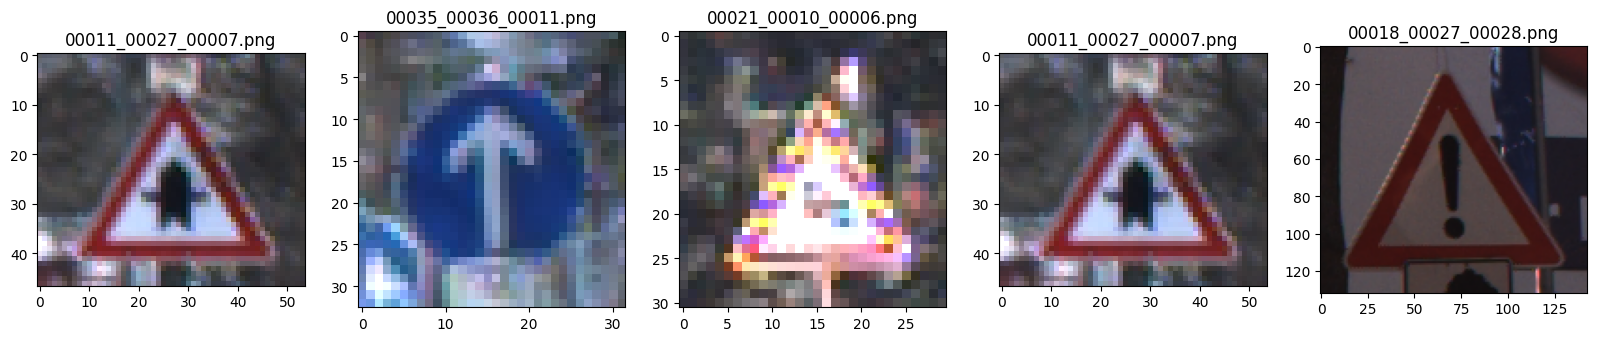

In [2]:
plt.figure(figsize=(20,20))
img_folder=r'/home/mjatheendran/code/Matuschkalulu/traffic_signs/raw_data/Train/1'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Loading Datasets

In [13]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
    IMG_WIDTH=100
    IMG_HEIGHT=100
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            #image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name =create_dataset(r'/home/mjatheendran/code/Matuschkalulu/traffic_signs/raw_data/Train/')

In [14]:
def split_preprocess(X,y, data_path):
    #X, y= create_dataset(data_path)
    X, y = shuffle(X, y)
    X= np.array(X)
    y= np.array(y)
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)
    y_train= y_train.astype(int)
    y_test= y_test.astype(int)
    X_train_preproc= preprocess_input(X_train).astype('float')
    X_test_preproc= preprocess_input(X_test).astype('float')
    return X_train_preproc, X_test_preproc, y_train, y_test
X_train_preproc, X_test_preproc, y_train, y_test= split_preprocess(img_data, class_name, img_folder)

In [44]:
#images = tf.convert_to_tensor(img_data)
#images.shape
#y_class = np.array(class_name)

## Preprocessing/Scaling/Re-sizing Images 

## Train & Test Datasets

In [5]:
from sklearn.utils import shuffle
import numpy as np

X = img_data
y = class_name
X, y = shuffle(X, y)
#print(X)
#print(y)

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=True)
X_train_tf = tf.convert_to_tensor(X_train)
y_train_array = np.array(y_train).astype(int)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_array = np.array(y_test).astype(int)

2023-06-14 11:07:01.847253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mjatheendran/.pyenv/versions/3.10.6/envs/traffic_signs/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-14 11:07:01.847336: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-14 11:07:01.847361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BG3MV8C): /proc/driver/nvidia/version does not exist
2023-06-14 11:07:01.847769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

## Base Model Initialization Function

In [6]:
def initialize_base_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    # YOUR CODE HERE
    model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same', input_shape=(100, 100, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Fourth Convolution & MaxPooling
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Fifth Convolution & MaxPooling
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Flattening
    # YOUR CODE HERE
    model.add(layers.Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    # YOUR CODE HERE
    model.add(layers.Dense(10, activation='relu'))

    
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    # YOUR CODE HERE
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ### Model compilation
    # YOUR CODE HERE
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model


## VGG Model Initialization Function

In [15]:
def initialize_VGG_model():
    
    base_model= VGG16(weights='imagenet', input_shape=X_train_preproc[0,:,:].shape, include_top=False)
    base_model.trainable=False
    last_layer= base_model.output

    x= Flatten()(last_layer)
    x= Dense(1024, activation= 'relu')(x)
    x= Dense(512, activation= 'relu')(x)
    x= Dense(10, activation= 'relu')(x)
    output= Dense(1, activation= 'sigmoid')(x)

    model= Model(base_model.input, output)

    model.compile(loss='binary_crossentropy',
                optimizer = Adam(learning_rate= 1e-4),
                metrics=['accuracy'])
    return model

## Data Augmentation for VGG Model

In [31]:
def data_augment(X_train_preproc, y_train, X_test_preproc, y_test,num, batch_size):
    train_datagen = ImageDataGenerator(featurewise_center = False,
        featurewise_std_normalization = False,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        zoom_range = (0.8, 1.2))

    train_datagen.fit(X_train_preproc)
    train_size= int(X_train_preproc.shape[0] *num)

    X_train_aug= X_train_preproc[:train_size].astype('float')
    y_train_aug= y_train[:train_size].astype(int)

    X_val= X_train_preproc[train_size:].astype('float')
    y_val= y_train[train_size:].astype(int)

    X_test_preproc= X_test_preproc.astype('float')
    y_test= y_test.astype(int)

    train_flow = train_datagen.flow(X_train_aug, y_train_aug, batch_size = batch_size)
    return train_datagen, X_train_aug, y_train_aug, X_val, y_val, X_test_preproc, y_test

## Plotting History and Checking fitting function

In [7]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

## Base Model Compile and Train


Processing using Base Model...

Training model...
Epoch 1/25
33/33 [==============================] - 3s 60ms/step - loss: 0.6844 - accuracy: 0.5862 - val_loss: 0.6667 - val_accuracy: 0.7143
Epoch 2/25
33/33 [==============================] - 2s 48ms/step - loss: 0.6317 - accuracy: 0.7318 - val_loss: 0.5553 - val_accuracy: 0.7857
Epoch 3/25
33/33 [==============================] - 2s 49ms/step - loss: 0.4772 - accuracy: 0.8046 - val_loss: 0.4790 - val_accuracy: 0.8125
Epoch 4/25
33/33 [==============================] - 2s 50ms/step - loss: 0.3649 - accuracy: 0.8506 - val_loss: 0.4255 - val_accuracy: 0.8214
Epoch 5/25
33/33 [==============================] - 2s 56ms/step - loss: 0.3449 - accuracy: 0.8467 - val_loss: 0.4956 - val_accuracy: 0.7857
Epoch 6/25
33/33 [==============================] - 2s 62ms/step - loss: 0.3903 - accuracy: 0.8391 - val_loss: 0.3898 - val_accuracy: 0.8393
Epoch 7/25
33/33 [==============================] - 2s 62ms/step - loss: 0.3045 - accuracy: 0.8697 - va

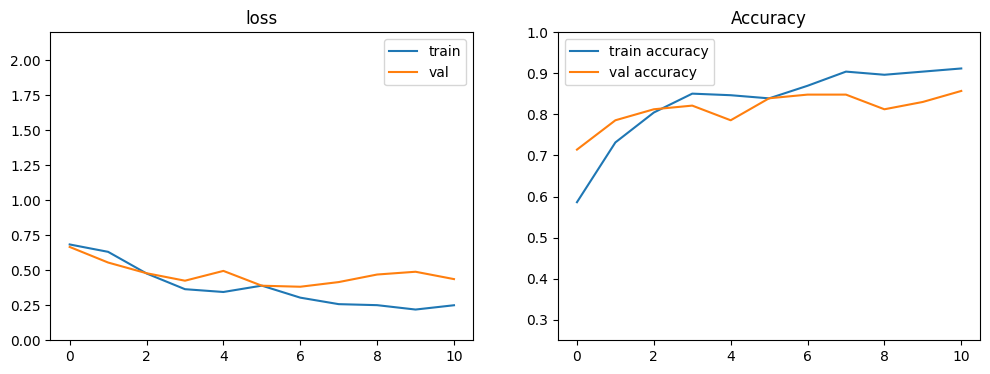

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
#es = EarlyStopping(patience=4 ,restore_best_weights=True)
#es = EarlyStopping()
#model = initialize_model()
# Fit the model on the train data
#history = model.fit(X_train_tf, y_train_array, validation_split=0.3, epochs=25, batch_size=8, callbacks=[es], verbose=1)


def train_base_model(model: Model, X: np.ndarray, y: np.ndarray, batch_size=8, patience=4,
                     validation_data=None, validation_split=0.3):
    

    """
    Fit the model and return a tuple (fitted_model, history)
    """
    print(Fore.BLUE + "\nTraining model..." + Style.RESET_ALL)

    es = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    es = EarlyStopping(patience=4 ,restore_best_weights=True)
    model = initialize_base_model()
    # Fit the model on the train data
    history = model.fit(X, y, validation_split=0.3, epochs=25, batch_size=8, callbacks=[es], verbose=1)

    print(f"✅ Model trained with min val ACCURACY: {round(np.min(history.history['val_accuracy']), 2)}")

    return model, history


def evaluate_base_model(model: Model, X: np.ndarray, y: np.ndarray, batch_size=16):

    """
    Evaluate trained model performance on the dataset
    """
    print(Fore.BLUE + f"\nEvaluating model on {len(X)} rows..." + Style.RESET_ALL)
    if model is None:
        print(f"\n❌ No model to evaluate")
        return None

    metrics = model.evaluate(x=X, y=y, batch_size=batch_size, verbose=0, return_dict=True)
    loss = metrics["loss"]
    accuracy = metrics["accuracy"]

    print(f"✅ Model evaluated, Accuracy: {round(accuracy, 2)}")
    return metrics

print(Fore.GREEN + f"\nProcessing using Base Model..." + Style.RESET_ALL)
model1 = initialize_base_model()
#model1, history1 = train_base_model(model1, X_train_preproc, y_train)
model1, history1 = train_base_model(model1, X_train_tf, y_train_array)
plot_history(history1)
base_model_score = evaluate_base_model(model1, X_test_tf, y_test_array)

    

## VGG Model Compile and Train


Processing using VGG Model...
Epoch 1/50
10/10 [==============================] - 59s 6s/step - loss: 0.7505 - accuracy: 0.7718 - val_loss: 0.4343 - val_accuracy: 0.8217
Epoch 2/50
10/10 [==============================] - 57s 6s/step - loss: 0.0912 - accuracy: 0.9664 - val_loss: 0.2726 - val_accuracy: 0.8837
Epoch 3/50
10/10 [==============================] - 58s 6s/step - loss: 0.0254 - accuracy: 0.9966 - val_loss: 0.2655 - val_accuracy: 0.8992
Epoch 4/50
10/10 [==============================] - 57s 6s/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2538 - val_accuracy: 0.8992
Epoch 5/50
10/10 [==============================] - 57s 6s/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.9070
Epoch 6/50
10/10 [==============================] - 57s 6s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2455 - val_accuracy: 0.9070
Epoch 7/50
10/10 [==============================] - 59s 6s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2458 - val_accura

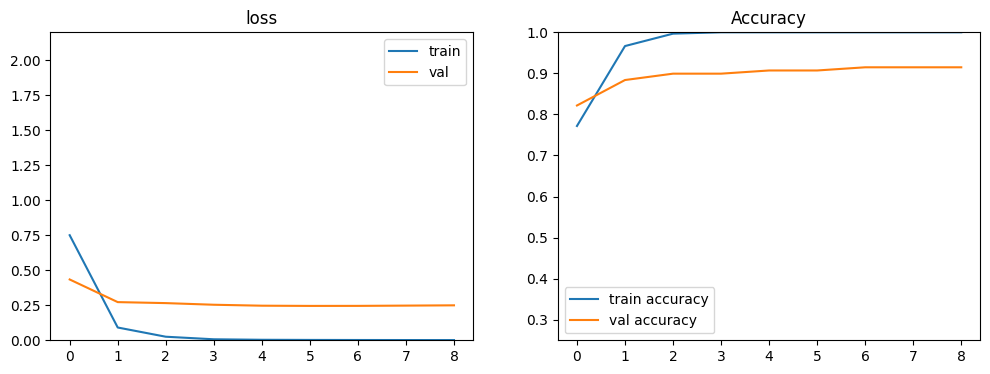

In [16]:
def train_VGG_model(model, X, y, validation_split, batch_size, patience):
    
    es= EarlyStopping(patience=patience, restore_best_weights=True, monitor= 'val_accuracy')
    history= model.fit(X, y, validation_split=validation_split, batch_size=batch_size, epochs=50, callbacks=[es],\
                  verbose=1)
    return model, history

def model_VGG_evaluate(model, X, y):
    
    score= model.evaluate(X, y)[1]
    print(f"✅ Model evaluated, Accuracy: {round(score, 2)}")
    return f'Test score= {score:.2f}'

print(Fore.YELLOW + f"\nProcessing using VGG Model..." + Style.RESET_ALL)
model= initialize_VGG_model()
model, history= train_VGG_model(model, X_train_preproc, y_train, 0.3, 32, 2)
plot_history(history)
vgg_model_score= model_VGG_evaluate(model, X_test_preproc, y_test)



## Data Augmentation VGG Model Compile and Train

In [36]:
def train_VGG_augment(model_aug, train_datagen, X_train_aug, y_train_aug, X_val, y_val, batch_size, patience):
    train_flow = train_datagen.flow(X_train_aug, y_train_aug, batch_size = batch_size)
    es = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=patience,verbose=2
                                                      ,mode="max",min_delta=0.0001,cooldown=0,min_lr=0, momentum= 0.9)

    history_aug = model_aug.fit(train_flow,
                          epochs = 50,
                          callbacks = [es],
                          validation_data = (X_val, y_val))

    return model_aug, history_aug

print(Fore.MAGENTA + f"\nProcessing using Data Augmentation & VGG Model..." + Style.RESET_ALL)
train_datagen, X_train_aug, y_train_aug, X_val, y_val, X_test, y_test= data_augment(X_train_preproc, y_train, X_test_preproc, y_test, 0.80, 64)
model_aug= initialize_VGG_model()
model_aug, history_aug= train_VGG_augment(model_aug, train_datagen, X_train_aug, y_train_aug, X_val, y_val, 64, 2)
plot_history(history_aug)
aug_VGG_score= model_VGG_evaluate(model_aug, X_test_preproc, y_test)


Processing using Data Augmentation & VGG Model...
Epoch 1/50
6/6 [==============================] - 54s 9s/step - loss: 0.8621 - accuracy: 0.4868 - val_loss: 0.7049 - val_accuracy: 0.4186 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - 51s 9s/step - loss: 0.7067 - accuracy: 0.4809 - val_loss: 0.6778 - val_accuracy: 0.5814 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 52s 10s/step - loss: 0.6997 - accuracy: 0.5630 - val_loss: 0.7460 - val_accuracy: 0.4186 - lr: 1.0000e-04
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.5279
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
6/6 [==============================] - 51s 10s/step - loss: 0.7066 - accuracy: 0.5279 - val_loss: 0.6640 - val_accuracy: 0.5814 - lr: 1.0000e-04
Epoch 5/50
6/6 [==============================] - 52s 9s/step - loss: 0.6707 - accuracy: 0.5836 - val_loss: 0.6692 - val_accuracy: 0.5930 - lr: 1.0000e-05
Epoch 6/50
6/6 

Epoch 37/50
2/6 [=========>....................] - ETA: 33s - loss: 0.6883 - accuracy: 0.5059

KeyboardInterrupt: 

## Model Summary and Parameters

In [120]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 100, 100, 8)       224       
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 50, 50, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 24, 24, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 11, 11, 32)     

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

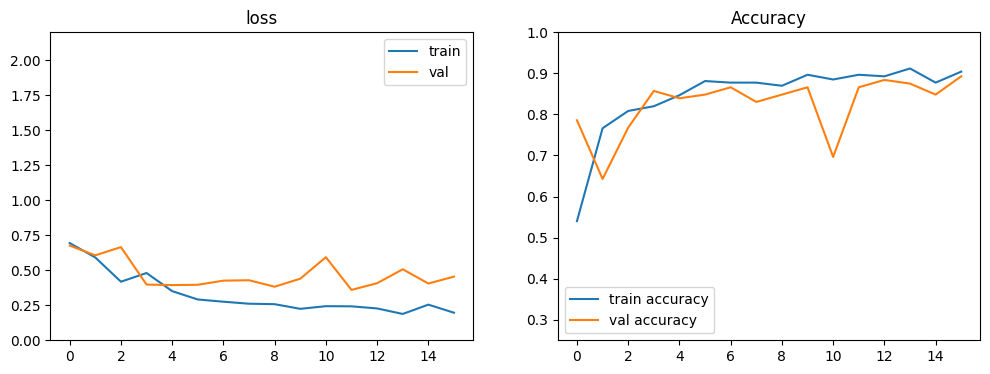

In [121]:
plot_history(history)

## Model Evaluation and Probability Prediction

In [124]:
model.evaluate(X_test_tf, y_test_array)

6/6 [==============================] - 1s 49ms/step - loss: 0.3447 - accuracy: 0.8634


[0.34467172622680664, 0.8633540272712708]